# **CS2302 Data Structures**
**Assignment:** Lab 1 - 2D Lists, Sets, Dictionaries, Backtracking and Sudoku

**Author:** Olac Fuentes

**Modified by:** Daniel Mejia

**Last modified:** October 10, 2024


## Student Information
Before proceeding any further, make sure to create a copy of this notebook and change the information below to match yours.

**Make your own copy of the notebook before working on it!**
> (File > Save a Copy in Drive)


In [1]:
#@title  { run: "auto", display-mode: "form" }
student_id = "80532860" #@param {type:"string"}
first_name = "Eric" #@param {type:"string"}
last_name = "Quezada" #@param {type:"string"}

## Academic Integrity Statement
This work is to be done individually. It is not permitted to share, reproduce, or alter any part of this assignment for any purpose. Students are not permitted from sharing code, uploading this assignment online in any form, viewing, receiving, or modifying code written from anyone else. This assignment is part of an academic course at The University of Texas at El Paso and a grade will be assigned for the work produced individually by the student.

## Copyright Notice
This work is protected by U.S. Copyright law. Any redistribution of this work is strictly prohibited.

## Guidelines
**PLEASE READ THIS CAREFULLY!**

This Colab notebook contains all the starter code needed for the lab along with some explanations and hints.

**DO NOT CHANGE ANY OF THE FUNCTION NAMES OR PARAMETERS**

As the code will be auto-graded by another program, changing any of the function names or parameters will result in you getting 0 points for that problem. Therefore do not change any function names or parameters. Feel free to add more functions, test cases, and any other code as long as you do not modify the pre-existing function names.


## Introduction
Sudoku is a popular game that involves logic, deduction and problem solving​​. If you are not familiar with the game, a detailed description can be found here: https://en.wikipedia.org/wiki/Sudoku

For this lab, you will practice using lists, sets and dictionaries and apply backtracking, a very useful algorithm design technique.

The initial version of your program should be able to solve simple Sudoku problems, while the more advanced one, based on backtracking, should be able to solve all problems.

The following Sudoku class provides part of an implementation of a program to store and display a Sudoku puzzle.

In [17]:
import matplotlib.pyplot as plt
import copy

class Sudoku:

    def __init__(self, A):
        self.S = A

    def draw(self, title='', show_rc_nums=False, show_valid_vals=False):
        # Draw lines
        fig, self.ax = plt.subplots(figsize=(8,8))
        for i in range(0,10,3):
            self.ax.plot([i,i],[0,9],linewidth=2,color='k')
            self.ax.plot([0,9],[i,i],linewidth=2,color='k')
        for i in range(1,9):
            self.ax.plot([i,i],[0,9],linewidth=1,color='k')
            self.ax.plot([0,9],[i,i],linewidth=1,color='k')

        # Print row and column numbers if desired
        if show_rc_nums:
            for i in range(9):
                self.ax.text((-.5),(i+.5), str(i), size=12,color = 'r',
                    ha="center", va="center")
                self.ax.text((i+.5),(-.5), str(i), size=12,color = 'r',
                    ha="center", va="center")

        # Print known values
        for i in range(9):
            for j in range(9):
                if self.S[i][j] != 0:
                    self.ax.text((j+.5),(i+.5), str(self.S[i][j]), size=18,
                        ha="center", va="center")

        # Print valid values using small green numbers, if desired
        if show_valid_vals and hasattr(self,'V'):
            for i in range(9):
                for j in range(9):
                    if self.S[i][j] == 0:
                        for n in self.V.get((i,j), []):
                            n1 = n-1
                            self.ax.text((j+.5+(n1%3-1)*.25),(i+.5+(n1//3-1)*.25), str(n), size=10,
                                         color = 'g', ha="center", va="center")

        self.ax.axis('off')
        self.ax.set_title(title, y=-.05,size = 18)
        self.ax.set_aspect(1.0)
        self.ax.invert_yaxis()
        plt.show()

    def find_neighbors(self):
        # Fill out the dictionary self.N such that for each cell (r, c),
        # self.N[(r, c)] contains a set of coordinate tuples (i, j) of all cells
        # that are in the same row, column, or 3x3 subgrid as the cell (r, c), excluding (r, c) itself.
        # For example, for cell (0, 0), self.N[(0, 0)] should include all cells in row 0,
        # all cells in column 0, and all cells in the top-left 3x3 subgrid, except for (0, 0).
        # This dictionary will be used to quickly access neighboring cells when checking for constraints.
        self.N = {}
        #Iterate through rows r and columns c
        for r in range(9):
          for c in range(9):
            # initialize set to contain neighbors coordinates
            neighbors = set()

            # call helper method containing coordinates for the rows and update set
            neighboring_row = self._find_neighbors_row(r, c)
            neighbors.update(neighboring_row)

            # call helper method containing coordinates for the columns and update set
            neighboring_col = self._find_neighbors_in_col(r, c)
            neighbors.update(neighboring_col)

            # call helper method containing coordinates for the 3x3 subgrid and update set
            target_num = self._find_3x3_subgrid(r, c)
            neighbors.update(target_num)

            # pass the coordinates of the set containing neighbors to dictionary
            self.N[(r,c)] = neighbors


    # Helper method to find neighbors within row
    def _find_neighbors_row(self, r, c):
      neighbors_in_row = set()
      for col in range(9): # iterate through columns
        if col != c: # exclude current column
          neighbors_in_row.add((r, col)) # add coordinates to set as tuple
      return neighbors_in_row


    # Helper method to find neighbors within column
    def _find_neighbors_in_col(self, r, c):
      neighbors_in_col = set()
      for row in range(9): # iterate through rows
        if row != r: # exclude current row
          neighbors_in_col.add((c, row)) # add coordinates to set
      return neighbors_in_col


    def _find_3x3_subgrid(self, r, c):
      target = set()
      # find the top-left corner of the 3x3 subgrid
      start_row = (r // 3) * 3 # start row starts at one
      start_col = (c // 3) * 3 # start col starts at one
      for i in range(start_row, start_row + 3): # iterate through rows
          for j in range(start_col, start_col + 3): # iterate through cols
              if (i, j) != (r, c): # check coordinates
                  target.add((i, j))  # add neighbors of subgrid to set
      return target


    def init_valid(self):
        # Using the neighbor dictionary self.N from find_neighbors(), fill out the dictionary self.V.
        # For each cell (r, c), self.V[(r, c)] should contain the set of valid numbers (1-9) that can be placed in that cell
        # without violating Sudoku rules (i.e., no duplicates in the same row, column, or 3x3 subgrid).
        # If a number is already placed in cell (r, c) in self.S (i.e., self.S[r][c] != 0),
        # then self.V[(r, c)] should be an empty set since the cell's value is fixed.
        # For empty cells, compute the set by excluding numbers that appear in any of its neighboring cells in self.N[(r, c)].
        self.V = {}


    def solve(self):
        return 0


    def solve_backtrack(self):
        return 0



We will represent a Sudoku puzzle with a 2D array. If a given cell has already been filled, the corresponding array entry will contain the number in the cell; otherwise it will contain 0.

Running the following cells shows an example of creating and displaying a  Sudoku object.


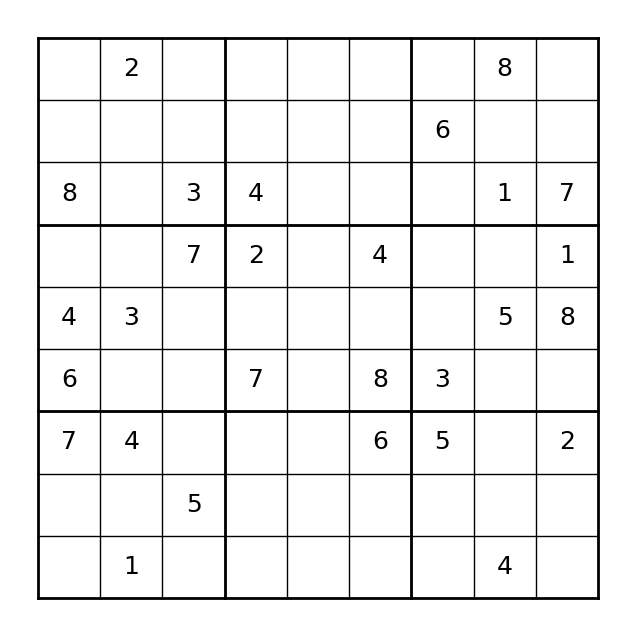

In [13]:
B = [[0, 2, 0, 0, 0, 0, 0, 8, 0], [0, 0, 0, 0, 0, 0, 6, 0, 0], [8, 0, 3, 4, 0, 0, 0, 1, 7],
    [0, 0, 7, 2, 0, 4, 0, 0, 1], [4, 3, 0, 0, 0, 0, 0, 5, 8], [6, 0, 0, 7, 0, 8, 3, 0, 0],
    [7, 4, 0, 0, 0, 6, 5, 0, 2], [0, 0, 5, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 4, 0]]
S = Sudoku(B)
S.draw()

We can also display the row and column numbers to make analysis easier.

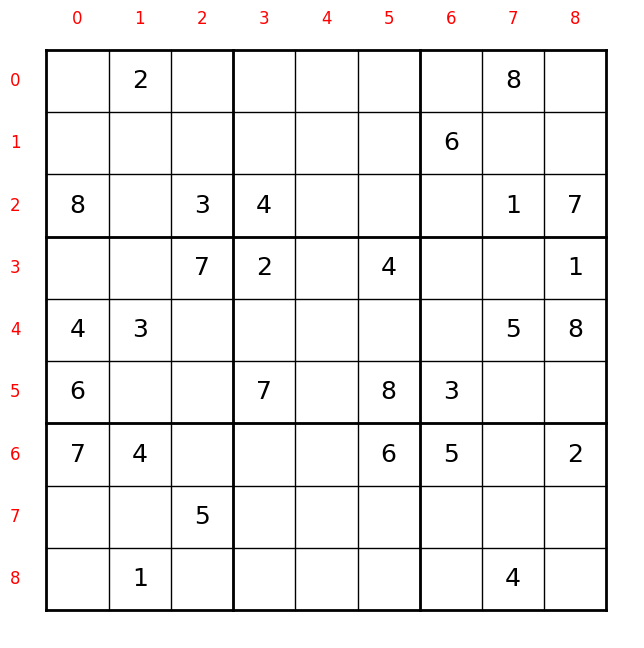

In [4]:
S.draw(show_rc_nums=True)

When solving a Sudoku by hand, we often write the numbers that can be placed in every empty cell, hoping to find a cell where only one number can be placed.

For the puzzle above, we would obtain the following:

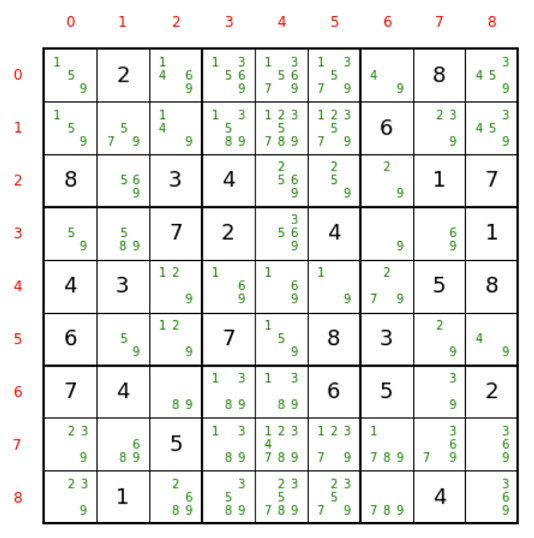

How was this obtained?

For every empty cell, we start with a set of all possible values. Then we remove the values that are present in the same row, column and region. The remaining values are the legal values.

For example, consider cell (4,5)

Initially S = {1,2,3,4,5,6,7,8,9}

We now remove from S the numbers that are in row 4, which are {4,3,5,8}

We are left with S = {1,2,6,7,9}

We now remove the elements of S that are in column 5 (which contains {4,8,6}]).

We are left with S = {1,2,7,9}

We now remove the elements of L that are in the same 3-by-3 region as cell (4,5) (which contains {2,4,7,8}).

We are left with S = {1,9}

Notice that S cannot be empty, unless the puzzle is unsolvable.

What happens if S has a single number? Then we know that that number should be placed in that cell.

For example, in the image above, we know that 9 should be placed in cell (3,6).

The code provided will draw the valid numbers in the corresponding cells, but the initial version of the valid numbers function just returns all integers from 1 to 9. It will be your job to write that function correctly.

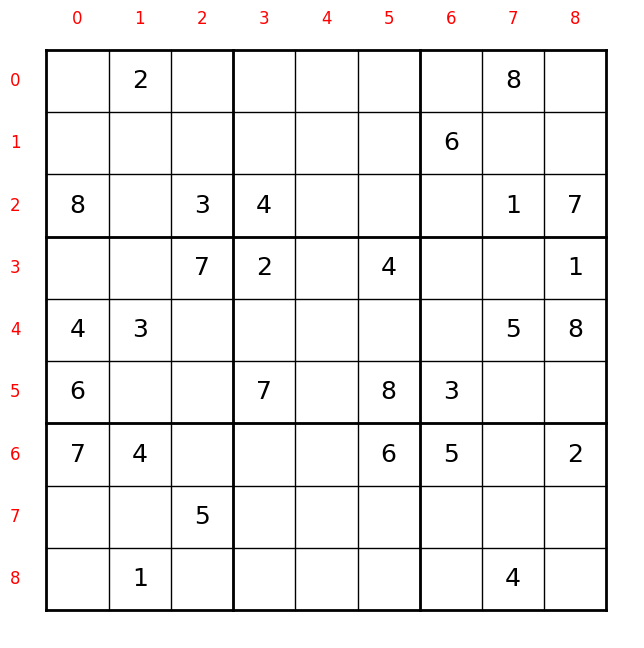

In [5]:
S.draw(show_rc_nums=True, show_valid_vals=True)

## Your assignment

### Part 1

In this part you will implement functions for reading and storing puzzles and for extracting data to solve them.

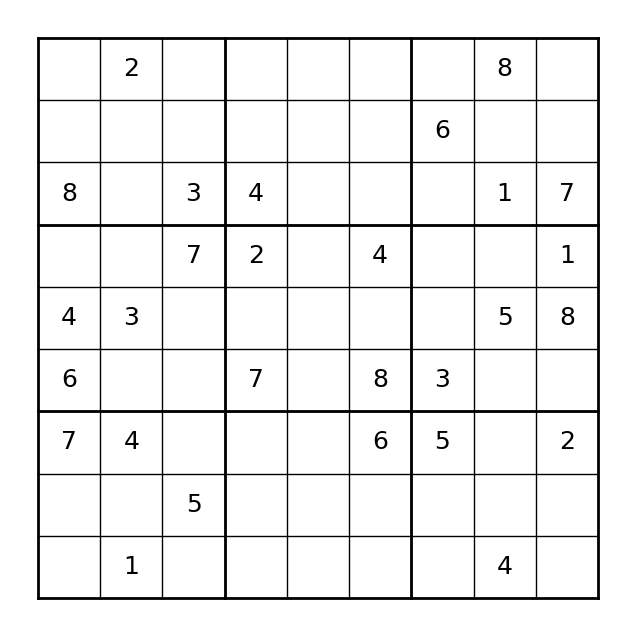

In [10]:
s = [[0, 2, 0, 0, 0, 0, 0, 8, 0], [0, 0, 0, 0, 0, 0, 6, 0, 0], [8, 0, 3, 4, 0, 0, 0, 1, 7],
    [0, 0, 7, 2, 0, 4, 0, 0, 1], [4, 3, 0, 0, 0, 0, 0, 5, 8], [6, 0, 0, 7, 0, 8, 3, 0, 0],
    [7, 4, 0, 0, 0, 6, 5, 0, 2], [0, 0, 5, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 4, 0]]
S = Sudoku(s)
S.draw()

**1)** Implement the function *find_neighbors* that fills out a dictionary *N* where *N[(r,c)]* contains the set of cells that cannot hold the same value as cell *(r,c)*.

Notice that for all *(r,c)*, *N[(r,c)]* must contain exactly 20 elements.

Why? For cell *(r,c)*, there are 8 cells in the same region as *(r,c)* (not counting *(r,c)*), there are also 6 cells in row *r* that are not in the same region as *(r,c)* and 6 cells in column *c* that are not in the same region as *(r,c)*.



In [20]:
s = [[0, 2, 0, 0, 0, 0, 0, 8, 0], [0, 0, 0, 0, 0, 0, 6, 0, 0], [8, 0, 3, 4, 0, 0, 0, 1, 7],
    [0, 0, 7, 2, 0, 4, 0, 0, 1], [4, 3, 0, 0, 0, 0, 0, 5, 8], [6, 0, 0, 7, 0, 8, 3, 0, 0],
    [7, 4, 0, 0, 0, 6, 5, 0, 2], [0, 0, 5, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 4, 0]]
S = Sudoku(s)
S.find_neighbors()
print(S.N.keys())
print(S.N[(0,0)])
print(len(S.N[(0,0)]))

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)])
{(0, 1), (0, 7), (1, 2), (0, 4), (2, 1), (1, 1), (0, 3), (2, 0), (0, 6), (0, 2), (0, 5), (2, 2), (1, 0), (0, 8)}
14


**2)** Implement the function *init_valid()* that fills out a dictionary *V* such that *V[(r,c)]* contains the set of numbers that can be written in cell *(r,c)* without breaking any of the rules.



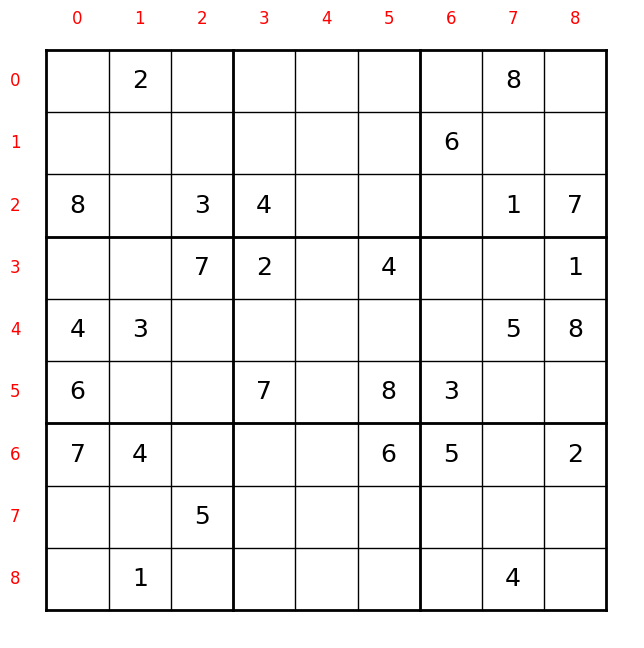

KeyError: (0, 0)

In [19]:
s = [[0, 2, 0, 0, 0, 0, 0, 8, 0], [0, 0, 0, 0, 0, 0, 6, 0, 0], [8, 0, 3, 4, 0, 0, 0, 1, 7],
    [0, 0, 7, 2, 0, 4, 0, 0, 1], [4, 3, 0, 0, 0, 0, 0, 5, 8], [6, 0, 0, 7, 0, 8, 3, 0, 0],
    [7, 4, 0, 0, 0, 6, 5, 0, 2], [0, 0, 5, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 4, 0]]
S = Sudoku(s)
S.find_neighbors()
S.init_valid()
S.draw(show_rc_nums=True, show_valid_vals=True)
print(S.V[(0,0)])
print(S.V[(3,6)])

How to find the valid values?

For every cell *(r,c)* in the puzzle, initialize *V[(r,c)]* with all valid values *(V[(r,c)] = set(range(1,10)))*

For every filled cell in the original puzzle (such that *S.S[r][c] !=0*), remove *S.S[r][c]* from all neighbors of *(r,c)* (that is, all cells in *N[(r,c)]*)..

For example, consider an initial puzzle with only one filled cell, as shown below.

All '2's are removed from the valid sets of the cells in the same row, column, and region as cell (0,1).

s = [[0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


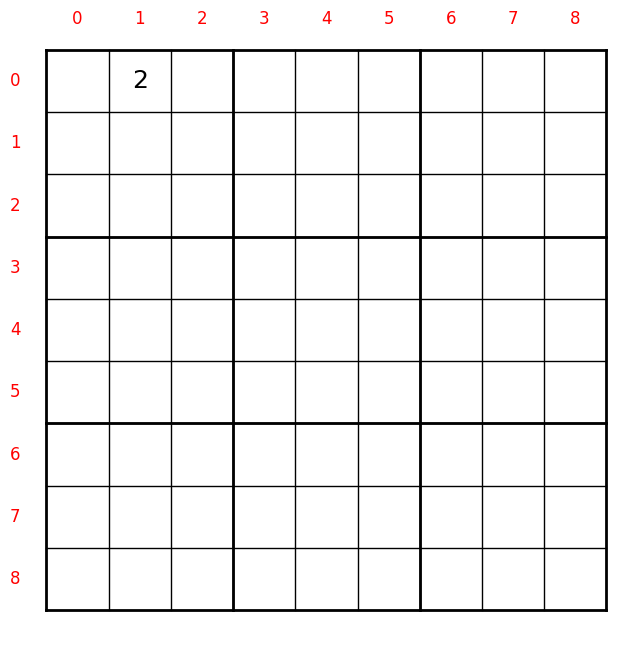

In [18]:
s = [[0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
print('s =',s)
S = Sudoku(s)
S.find_neighbors()
S.init_valid()
S.draw(show_rc_nums=True, show_valid_vals=True)

### Part 2

In this part you will implement a strategy for solving some simple puzzles.

Implement the function *solve()* that attempts to solve the puzzle using the strategy described below.



```
solve()
  Compute the set of valid values V[(r,c)] for every cell (r,c).
  known = set()
  For every cell whose set of valid values has length 1, add (val, r, c) to the known set, where val is the (only) element of set V[(r,c)].
  while known set is not empty:
    (val,r,c)  = known.pop() # Remove an element from known set
    S[r,c] = val             # Set value in puzzle  
    V[(r,c)] = set()         # Make the candidate set for cell (r,c) empty, since it has already been filled.  
    update sets              # Remove val from all sets that are in the same row, column or region as cell (r,c). Add to known set all sets whose length is reduced to 1 by this update.
  
  If the puzzle has been solved (that is, all cells in S are filled), return 1
  If there is a cell (r,c) that has not been filled but whose set of valid values is empty, return -1
  Return 0 - the puzzle has not been solved, but it still may have a solution

```



easy21.txt: [easy21.txt](https://drive.google.com/file/d/134lF_ksWmD_QX2wWf4ng2OX0f9xojG8p/view?usp=sharing)

hard1000.txt: [hard1000.txt](https://drive.google.com/file/d/19uqNlkhwHi-mOJ_k9lRrhjUsTHSicxu3/view?usp=sharing) (Note: There are only 10 puzzles)

Upload easy21.txt file

In [ ]:
from google.colab import files
uploaded = files.upload()

All puzzles in file "easy21.txt", except for the last one, are solvable.



In [ ]:
f = open("easy21.txt", "r")
count = [0,0,0]
ss = [s for s in f.read().split('\n')]


def convert_to_board(s):
  board = []
  counter = 0
  row = []
  for c in s:
    if counter == 9:
      board.append(row)
      row = []
      counter = 0
    if c != '.':
      row.append(int(c))
    else:
      row.append(0)
    counter += 1
  if row:
    board.append(row)
  return board

for s in ss:
  board = convert_to_board(s)
  S = Sudoku(board)
  S.draw()
  sol = S.solve()
  S.draw()
  print(sol)
  print()
  count[sol]+=1

print('solved puzzles:',count[1])
print('unsolved puzzles:',count[0])
print('unsolvable puzzles:',count[-1])

### Part 3
In this part you will implement a strategy for solving all solvable puzzles using backtracking.

If there are no cells with a single valid value, we have to guess among the valid values in a given cell; if the guess works, we return the result, otherwise we backtrack.

For example, consider the following attempted solution:

In [ ]:
s='3..2........1.7...7.6.3.5...7...9.8.9...2...4.1.8...5...9.4.3.1...7.2........8..6'
board = convert_to_board(s)
S = Sudoku(board)
S.draw()
sol = S.solve()
S.draw(show_valid_vals=True)



At this point, we cannot make any progress, since all cells have at least 2 valid values.

We can solve the puzzle using a backtracking approach as follows:

Choose a cell that has not been filled:

Suppose we pick cell (0,5), with valid values {5,6}.

First we assume the correct value is 5, then try to find a solution for

s = '3..2.**5**......1.7...7.69345...7...9.8.9...2...4.1.8...5...9.4.3.1...7.2........8..6'

If we find a solution, we are done, otherwise we assume the correct value is

s = '3..2.**6**......1.7...7.69345...7...9.8.9...2...4.1.8...5...9.4.3.1...7.2........8..6'

and try to find a solution for that.

If neither solution works, the puzzle has no solution.

The following pseudocode can be used as a guide to implement backtracking.


```
def solve_backtrack(self):
  if sol == 1: # Solution found
    return sudoku.to_string()
  if sol == -1: # Solution found
    return None
  find unfilled cell (r,c) in self.S
  for every value v in V[(r,c)]:
    assume self.S[r][c] = v
    sol = self.solve_backtrack()
    if sol != None:
        return sol
  return None
```


In [ ]:
f = open("easy21.txt", "r")
count = [0,0,0]
ss = [s for s in f.read().split('\n')]
print(len(ss), 'strings read')
for s in ss:
  board = convert_to_board(s)
  sudoku = Sudoku(board)
  sudoku.draw()
  sol = sudoku.solve_backtrack()
  sudoku.draw()
  print(sol)
  count[sol]+=1

print('solved puzzles:',count[1])
print('unsolved puzzles:',count[0])
print('unsolvable puzzles:',count[-1])


Upload hard1000.txt file

All puzzles in file "hard1000.txt" are solvable with backtracking.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import time
f = open("hard1000.txt", "r")
count = [0,0,0]
ss = [s for s in f.read().split('\n')]
print(len(ss), 'strings read')
start = time.time()
for s in ss[:10]: # Pick the first few files for your initial experiments. Later you can try solving all of them
  board = convert_to_board(s)
  sudoku = Sudoku(board)
  sudoku.draw()
  sol = sudoku.solve_backtrack()
  sudoku.draw()
  print('solve_backtrack(s) result:\n',sol)
  if sol!=None:
    count[1]+=1
  else:
    count[-1]+=1
elapsed_time2 = time.time() - start
print('elapsed time using set', elapsed_time2,'secs')

print('solved puzzles:',count[1])
print('unsolved puzzles:',count[0])
print('unsolvable puzzles:',count[-1])

## Deadlines

1. Check-in - October 24, 2024 at 11:59pm
    *   Your code will not be graded, however, this check-in is required to earn credit on the lab. You will submit your progress up to this point (At minimum you should have Parts 1 and a majority of 2 completed). You will be evaluated only on the amount of progress that you have made (i.e., 1 - satisfactory progress, 0-unsatisfactory progress); solutions do not yet need to be complete, but should be reasonably progressed.
    *   Submit your progress by uploading the .ipynb file on Blackboard under "Lab 2 - Check-In"
2. Final Submission - October 31, 2024 at 11:59pm
    *   You should submit a completed lab assignment to include all appropriate source code above



## How to Submit

1. File > Download .ipynb
2. Go to Blackboard, find the submission page, and upload the .ipynb file you just downloaded.
